In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import grad, jit, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer import HMC, HMCECS, MCMC, NUTS, SA, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoNormal

from pu.pu_dynamics import *
from pu.load_data import *

from functools import partial
import seaborn as sns

%load_ext autoreload
%autoreload 2
 


/Users/vivekdharmangadansree/opt/miniconda3/envs/PUNumpyro/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Let's load scaled versions of all the data that we need
data_path = "../data" #Location where all data is stored

rhokl = [1,2,3]
macl = [1,2,3,4,5,6]
neutl = [1,2,3,4,5,6]
kcl = [1,2,3,4,5]
tal = [1,2,3]
tbl = [1,2,3,4,5,6]

dat_mac = load_file(data_path, "Macro", macl, 30)
dat_neut = load_file(data_path, "Neutro", neutl, 40)
dat_kc = load_file(data_path, "MCP", kcl, 1)
dat_rhok = load_file(data_path, "Keratinocyte", rhokl, 1)
dat_rhok = np.array(dat_rhok)
dat_rhok[:,0] = dat_rhok[:,0] -1
dat_rhok = jnp.array(dat_rhok)
dat_ta=load_file(data_path, "Ta", tal, 40)
dat_tb = load_file(data_path, "Tb", tbl, 15)


dat_mac = add_end_data(dat_mac, macl, 20, 1.0)
dat_neut = add_end_data(dat_neut, neutl, 20, 1.0)
dat_ta = add_end_data(dat_ta, tal, 20, 1.0)
dat_tb = add_end_data(dat_tb, tbl, 20, 1.0)
dat_rhok = add_end_data(dat_rhok, rhokl, 20, 1.0)
dat_kc = add_end_data(dat_kc, kcl, 20, 0.0)


timel = jnp.linspace(0,480,480)

id_rhok = timel.searchsorted(dat_rhok[:,0]*24)
id_rhon = timel.searchsorted(dat_neut[:,0]*24)
id_rhom = timel.searchsorted(dat_mac[:,0]*24)
id_ta   = timel.searchsorted(dat_ta[:,0]*24)

ids = (id_rhok, id_rhon, id_rhom, id_ta)        #Tuple of all observed time indices
dat = (dat_rhok[:,2], dat_neut[:,2], dat_mac[:,2], dat_ta[:,2])     #Tuple of all observed data points

In [7]:
def model(id=ids, data =None):
    """
    :id tuple(jnp.ndarray)  : Observed time indices of keratinocytes, neutrophils, macrophages and TNFa
    :data tuple(jnp.ndarray): Observed data points of keratinocytes, neutrophils, macrophages and TNFa
    """
    lkTa =numpyro.sample("lkTa", dist.Uniform(low=0.4, high=0.6))
    lkI1b =numpyro.deterministic("lkI1b", 0.07)
    lkR =numpyro.deterministic("lkR", 0.07)
    lkTb =numpyro.deterministic("lkTb", 0.2)

    lnKC =numpyro.deterministic("lnKC", 2.0)
    lnDa =numpyro.sample("lnDa", dist.Uniform(low=1.8, high=2.1))

    Tahf =numpyro.sample("Tahf", dist.Uniform(low=8.0, high=16.0))
    lm1Ta =numpyro.sample("lm1Ta", dist.Uniform(low=.75, high=1.25))
    I1bhfm1 =numpyro.sample("I1bhfm1", dist.Uniform(low=8.0, high=15.0))
    lm1I1b =numpyro.sample("lm1I1b", dist.Uniform(low=0.8, high=1.6))
    lmKcm1 =numpyro.deterministic("lmKcm1", 1.0)
    Tbhfm1 =numpyro.sample("Tbhfm1", dist.Uniform(low=5.0, high=10.0))
    lm1Tb =numpyro.deterministic("lm1Tb", 0.1)
    I1bhfm2 =numpyro.sample("I1bhfm2", dist.Uniform(low=5.0, high=9.0))
    lm2I1b =numpyro.sample("lm2I1b", dist.Uniform(low=1.0, high=1.5))
    Tbhfm2 =numpyro.deterministic("Tbhfm2", 10.0)
    lm2Tb =numpyro.deterministic("lm2Tb", 0.2)
    alpha_m1n =numpyro.deterministic("alpha_m1n", 0.0001)
    alpha_m1m2 =numpyro.deterministic("alpha_m1m2", 0.0001)

    sig1 =numpyro.sample("sig1", dist.HalfCauchy(scale=0.1))
    sig2 =numpyro.sample("sig2", dist.HalfCauchy(scale=0.1))
    sig3 =numpyro.sample("sig3", dist.HalfCauchy(scale=0.1))
    sig4 =numpyro.sample("sig4", dist.HalfCauchy(scale=0.1))

    par = jnp.array([lkTa, lkI1b,lkR, lkTb,lnKC, lnDa,Tahf, lm1Ta, I1bhfm1,lm1I1b,
                        lmKcm1, Tbhfm1, lm1Tb,I1bhfm2,lm2I1b, Tbhfm2,lm2Tb,alpha_m1n,
                        alpha_m1m2])
    times = jnp.linspace(0,480,480)

    ode_solution = acute_solver(par,times)
    #rhok_sol,rhon_sol,rhom_sol,ta_sol
    sol = numpyro.deterministic("sol",ode_solution)
    y_rhok = numpyro.sample('y_rhok', dist.Normal(ode_solution[0, ids[0]], sig1), obs=data[0])
    y_rhon = numpyro.sample('y_rhon', dist.Normal(ode_solution[1, ids[1]], sig2), obs=data[1])
    y_rhom = numpyro.sample('y_rhom', dist.Normal(ode_solution[2, ids[2]], sig3), obs=data[2])
    y_ta   = numpyro.sample('y_ta', dist.Normal(ode_solution[3, ids[3]], sig4), obs=data[3])
    


In [8]:
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_warmup=1,
    num_samples=1,
    num_chains=1,
    progress_bar=True
)
mcmc.run(PRNGKey(1),data=dat)
# mcmc.print_summary()

sample: 100%|██████████| 2/2 [00:20<00:00, 10.34s/it, 1 steps of size 2.34e+00. acc. prob=0.00]


In [9]:
auto_guide = numpyro.infer.autoguide.AutoNormal(model)
adam = numpyro.optim.Adam(step_size=0.01)
elbo = numpyro.infer.Trace_ELBO()
svi = numpyro.infer.SVI(model, auto_guide, adam, elbo)
svi_result = svi.run(jax.random.PRNGKey(1),5000,data=dat )


100%|██████████| 5000/5000 [01:33<00:00, 53.54it/s, init loss: 11746.1172, avg. loss [4751-5000]: 451.6145]


In [10]:
# Posterior distributions of model parameters
params = svi_result.params
predictive_guide = Predictive(auto_guide, params=params, num_samples=1000)
samples = predictive_guide(PRNGKey(3), data=None)

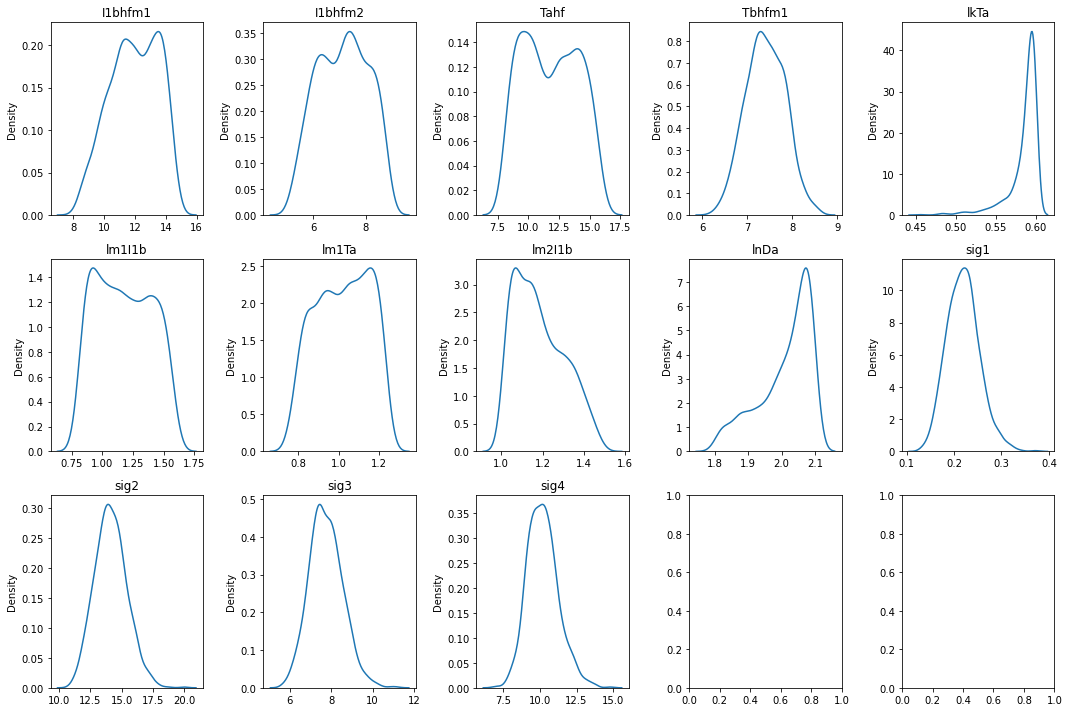

In [11]:
#Plotting 
naxes = len(samples)

fig, axes =  plt.subplots(3,5,figsize=(15,10))

axef = axes.flatten()
for i,par in enumerate(samples):
    sns.kdeplot(samples[f"{par}"],ax=axef[i])
    axef[i].set_title(f"{par}")

plt.tight_layout()

In [12]:
# Posterior predictive dynamics
predictive = Predictive(model, num_samples=1000)
svi_samples = predictive(PRNGKey(1),data=None)

TypeError: 'NoneType' object is not subscriptable

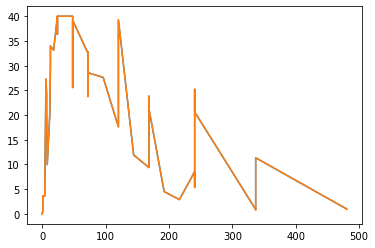

In [31]:
rhoks = svi_samples["y_rhon"]
rhok_mu = jnp.mean(rhoks,axis=0)
rhok_pi = jnp.percentile(rhoks, jnp.array([5, 95]), axis=0)
plt.plot(timel[id_rhon],rhok_mu)
plt.plot(timel[id_rhon],dat[1])
# plt.fill_between(timel[id_rhok],rhok_pi[0],rhok_pi[1])

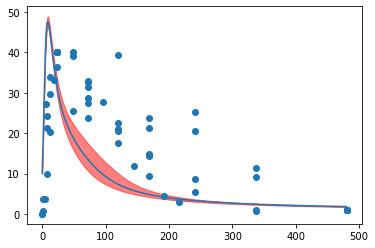

In [38]:
sol = svi_samples["sol"]
sol_mu = jnp.mean(sol,axis=0)
sol_pi = jnp.percentile(sol,jnp.array([5, 95]),axis=0)
plt.plot(timel, sol_mu[1,:])
plt.fill_between(timel, sol_pi[0,1,:],sol_pi[1,1,:],color='r',alpha=0.5)
plt.scatter(timel[id_rhon],dat[1])